In [1]:
import numpy as np 
import numpy.ma as ma
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import datetime

from tqdm import tqdm



import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
import glob
import pandas as pd
from astropy.table import Table, vstack

from ResidualUtils import getwavs, getspecpath, getapstarpath



matplotlib.rcParams.update({'xtick.labelsize':15,
                            'ytick.labelsize':15,
                            'axes.titlesize':15,
                            'axes.labelsize':15,
                            'font.size':15,
                            'xtick.top':True,
                            'xtick.minor.visible':True,
                            'ytick.minor.visible':True,
                            'xtick.major.size':4,
                            'xtick.minor.size':2,
                            'ytick.major.size':4,
                            'ytick.minor.size':2,
                            'ytick.right':True,
                            'xtick.direction':'in',
                            'ytick.direction':'in',
                            'font.family':'serif',
                            'text.usetex': False,
                            'pgf.texsystem': 'pdflatex'})
# plt.rcParams['pgf.texsystem'] = 'pdflatex'



flags = ['BADPIX',
'CRPIX',
'SATPIX',
'UNFIXABLE',
'BADDARK',
'BADFLAT',
'BADERR',
'NOSKY',
'LITTROW_GHOST',
'PERSIST_HIGH',
'PERSIST_MED',
'PERSIST_LOW',
'SIG_SKYLINE',
'SIG_TELLURIC']


from TolColors import tol_cmap
rainbow = tol_cmap('rainbow_PuRd')
sunset = tol_cmap('sunset')
iridescent = tol_cmap('iridescent')
for map in [rainbow, sunset, iridescent]:
    map.set_bad('white',1.)

In [2]:
tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits'
tabfile = 'allStarLite-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)

CA_fields = ['CA_161-06_btx', 'CA_161-06_btx', 'CA_162-11_btx', 'CA_163-05_btx', 'CA_163-08_btx',
             'CA_165-07_btx', 'CA_165-10_btx']
CA_inds = np.unique(np.concatenate([np.where(stars['FIELD'] == field)[0] for field in CA_fields]))
CA_stars = stars[CA_inds]
CA_clean = CA_stars[np.invert(np.logical_or.reduce([np.isnan(CA_stars['TEFF']), np.isnan(CA_stars['LOGG']), 
                                           np.isnan(CA_stars['M_H'])]))]

select_bitmasked = np.where((np.bitwise_and(stars['ASPCAPFLAG'], 23) == 0) | 
                            (np.bitwise_and(stars['ASPCAPFLAG'], 19) == 0))[0] # perhaps I should also bitmask CA_clean

stars = stars[select_bitmasked]
stars = stars[np.where((stars['TEFF_ERR'] < 600) & (stars['LOGG_ERR'] < 0.5) & (stars['M_H_ERR'] < 0.3))[0]]
stars = stars[np.where(np.abs(stars['GLAT']) > 10)[0]]

In [3]:
meta = Table(fits.open('ResidualsFiles/meta_table.fits')[1].data)

In [ ]:
def get_residual(teff, logg, m_h):
    rowselect = np.where(np.logical_and.reduce([teff >= meta['teff_low'], teff < meta['teff_high'], 
                    logg >= meta['logg_low'], logg < meta['logg_high'],
                   m_h >= meta['m_h_low'], m_h < meta['m_h_high']]))[0]
    if len(rowselect) != 1:
#         print('Wrong number of rows')
        return 
    
    
    row = meta[rowselect]
    j, k = (row['j_ind'], row['k_ind'])
    filename = row['fname'].item()
    hdulist = fits.open(filename)
    hdulist = np.array(hdulist)[1:].reshape(30,12)
    hdu = hdulist[j, k].item()
    return hdu

def get_residuals_from_tab(tab):
    residuals = []
    for row in tab:
        hdu = get_residual(row['TEFF'], row['LOGG'], row['M_H'])
        residuals.append(hdu)
    return residuals

def getspecpath(row):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    telescope = np.array(row['TELESCOPE'], dtype = str)
    field = np.array(row['FIELD'], dtype = str)
    sourceid = np.array(row['APOGEE_ID'], dtype = str)
#     length = len(sourceid)
    path = (specdir + specname).format(TELESCOPE = telescope, FIELD = field, SOURCEID = sourceid)
    return path

In [ ]:
def create_mask(bitmask, flags = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], skipflags = []):
    # https://www.sdss.org/dr14/algorithms/bitmasks/#APOGEE_PIXMASK
    if type(flags) is not list:
        flags = [flags]
    if type(skipflags) is not list:
        skipflags = [skipflags]

    mask = np.zeros(bitmask.shape)
    for i in flags:
        if i not in skipflags:
            mask[np.bitwise_and(bitmask, 2**i) == 2**i] = 1
    return mask

In [ ]:
star_row = CA_clean[0]
star = fits.open(getspecpath(star_row))
spec, model = (star[1].data, star[3].data)
stellar_res = np.divide(spec, model)



medres = get_residual(star_row['TEFF'], star_row['LOGG'], star_row['M_H']).data
res = medres[0, :]



In [ ]:
wavs = getwavs()

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(wavs, stellar_res)
ax.plot(wavs, stellar_res / res)
ax.plot(wavs, res)
ax.set_xlim()
ax.set_xlim(15250, 15500)
ax.set_ylim(0.9, 1.1)
plt.show()

In [ ]:
threshold = 0.05
for i in range(10):
    star_row = CA_clean[i]
    star = fits.open(getspecpath(star_row))
    spec, model = (star[1].data, star[3].data)
    stellar_res = np.divide(spec, model)
    mask = np.abs(stellar_res - np.nanmedian(stellar_res)) > threshold * np.nanmedian(stellar_res)
    stellar_res = ma.array(stellar_res, mask = mask)





    medres = get_residual(star_row['TEFF'], star_row['LOGG'], star_row['M_H']).data
    res = medres[0, :]
    res[res - np.nanmedian(res) > 0.01] = 1
    mask = np.abs(res - np.nanmedian(res)) > threshold * np.nanmedian(res)
    res = ma.array(res, mask = mask)



    wavs = getwavs()

    fig, axs = plt.subplots(nrows = 1, ncols =2, figsize = (16,6))
    axs[0].plot(wavs, stellar_res, label = 'Stellar Residual')
#     axs[0].set_xlim(15250, 15500)
    axs[0].set_xlim(15250, 15300)
    axs[0].set_ylim(0.9, 1.1)
    axs[0].set_xlabel('Wavelength (Angstroms)')
    axs[0].plot(wavs, res, label = 'Median Residual')
    axs[0].legend()


    
    axs[1].plot(wavs, stellar_res / res, label = 'Stellar Residual')
    axs[1].set_xlim()
#     axs[1].set_xlim(15250, 15500)
    axs[1].set_xlim(15250, 15300)
    axs[1].set_ylim(0.9, 1.1)
    axs[1].set_xlabel('Wavelength (Angstroms)')
    axs[1].plot(wavs, res, label = 'Median Residual')
    axs[1].legend()
    
    half_dib_highlight = 10
    axs[0].fill_between([15270 - half_dib_highlight, 15270 + half_dib_highlight], [1.2, 1.2], [0, 0], color = 'orange', alpha = 0.2)
    axs[1].fill_between([15270 - half_dib_highlight, 15270 + half_dib_highlight], [1.2, 1.2], [0, 0], color = 'orange', alpha = 0.2)
    
    axs[0].set_title('Uncorrected')
    axs[1].set_title('Corrected')

    
    plt.show()



In [ ]:
CA_clean

In [ ]:
plt.hist(1000/CA_clean['GAIAEDR3_PARALLAX'], bins = np.arange(0,1000, 50))
plt.xlim(200, 800)

plt.show()

plt.hist(CA_clean['VHELIO_AVG'])
plt.show()

In [4]:
plx = CA_clean['GAIAEDR3_PARALLAX'].data
rv = CA_clean['VHELIO_AVG'].data

# np.random.seed(0)
# near =CA_clean[np.random.choice(np.where((1000/plx > 300) & (1000/plx < 400))[0])]
# np.random.seed(0)
# far = CA_clean[np.random.choice(np.where((1000/plx > 550) & (1000/plx < 700))[0])]

# np.random.seed(0)
# vtoward = CA_clean[np.random.choice(np.where(rv < -50)[0])]
# np.random.seed(0)
# vzero = CA_clean[np.random.choice(np.where(np.abs(rv) < 10)[0])]
# np.random.seed(3)
# vaway = CA_clean[np.random.choice(np.where(rv > 50)[0])]



near = CA_clean[(1000/plx > 300) & (1000/plx < 400)][0]
far = CA_clean[(1000/plx > 550) & (1000/plx < 700) & (CA_clean['TEFF'] < 5000) & (CA_clean['LOGG'] < 3.5)][1]#18
# this is a red giant at a relatively far distance

vtoward = CA_clean[rv < -50][0]
vzero = CA_clean[np.abs(rv) < 10][9]
vaway = CA_clean[(rv > 50)][4]

selected = vstack([near, far, vtoward, vzero, vaway])

In [12]:
3e5*(15278 / 15272.42-1)


109.60934809283174

In [8]:
# get aspcapStar file path from an allstar table row
def get_aspcapStar(row):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    sas_url = 'https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    telescope = np.array(row['TELESCOPE'], dtype = str)
    field = np.array(row['FIELD'], dtype = str)
    sourceid = np.array(row['APOGEE_ID'], dtype = str)
#     length = len(sourceid)
    path = (specdir + specname).format(TELESCOPE = telescope, FIELD = field, SOURCEID = sourceid)
    path = '/Users/aidanmcbride/Documents/ISM/Files/aspcap/' + specname.format(SOURCEID = sourceid) # LOCAL MACHINE ONLY
    print((sas_url + specname).format(TELESCOPE = telescope, FIELD = field, SOURCEID = sourceid))
    return path

# get apStar/asStar file path from an aspcapStar hdulist
def get_apStar(hdulist):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/redux/dr17/stars/{TELESCOPE}/{FIELD}/'
    sas_url = 'https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/{TELESCOPE}/{FIELD}/'
    telescope = str(hdulist[4].data['TELESCOPE'][0])
    field = str(hdulist[4].data['FIELD'][0])
    fname = str(hdulist[4].data['FILE'][0])
    path = ((specdir + fname).format(TELESCOPE = telescope, FIELD = field))
    path = '/Users/aidanmcbride/Documents/ISM/Files/apstar/' + fname # LOCAL MACHINE ONLY
    print((sas_url + fname).format(TELESCOPE = telescope, FIELD = field))
    return path

aspcap = fits.open(get_aspcapStar(far))
apstar = get_apStar(aspcap)
far_ind = np.where((1000/plx > 550) & (1000/plx < 700) & (CA_clean['TEFF'] < 5000) & (CA_clean['LOGG'] < 3.5))[0][1]#18
print(far_ind)

https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/apo25m/CA_162-11_btx/aspcapStar-dr17-2M04101642+3535373.fits
https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/apo25m/CA_162-11_btx/apStar-dr17-2M04101642+3535373.fits
51


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


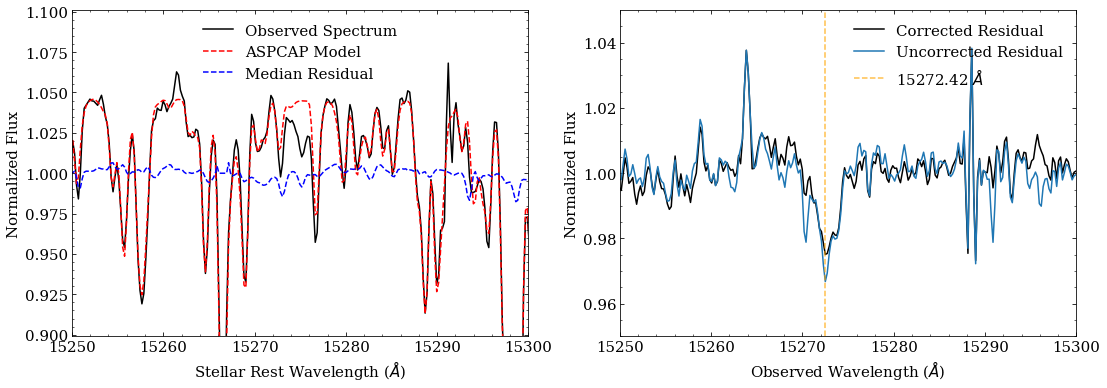

In [36]:
# wavshift = lambda wavs, rv : wavs / (1 -rv / 3e5)
wavshift = lambda wavs, rv : wavs *  ( 1 + rv / 3e5)
wavs_rv = wavshift(wavs, far['VHELIO_AVG'])

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))

star = fits.open(getspecpath(far))
spec, model = (star[1].data, star[3].data)
stellar_res = np.divide(spec, model)
mask = np.abs(stellar_res - np.nanmedian(stellar_res)) > threshold * np.nanmedian(stellar_res)
stellar_res = ma.array(stellar_res, mask = mask)



medres = get_residual(far['TEFF'], far['LOGG'], far['M_H']).data
res = medres[0, :]
res[res - np.nanmedian(res) > 0.01] = 1
mask = np.abs(res - np.nanmedian(res)) > threshold * np.nanmedian(res)
res = ma.array(res, mask = mask)


axs[0].plot()

# axs[0].set_title('Observed Spectrum + ASPCAP')
axs[0].plot(wavs, spec, label = 'Observed Spectrum', c= 'k')
axs[0].plot(wavs, model, label = 'ASPCAP Model', c = 'r', linestyle = 'dashed')
axs[0].plot(wavs, res, label = 'Median Residual', c = 'blue', linestyle = 'dashed')
axs[0].set_xlim(15250, 15300)
axs[0].set_ylim(0.899, 1.101)
axs[0].legend(frameon=False)


# axs[1].set_title('Interstellar Spectrum')
axs[1].plot(wavs_rv, stellar_res / res, label = 'Corrected Residual', c= 'k')
axs[1].plot(wavs_rv, stellar_res, label = 'Uncorrected Residual')


# axs[1].plot(wavs, stellar_res, label = 'Uncorrected')
axs[1].set_xlim()
axs[1].set_xlim(15250, 15300)
axs[1].set_ylim(0.95, 1.05)
axs[1].legend()

axs[0].set_xlabel('Stellar Rest Wavelength ($\AA$)')
axs[0].set_ylabel('Normalized Flux')
axs[1].set_xlabel(r'Observed Wavelength ($\AA$)')
axs[1].set_ylabel('Normalized Flux')
#     axs[1].legend()

# Highlight DIB location
half_dib_highlight = 5
DIBposition = 15272.42
# axs[0].plot([15270, 15270], [ymin, ymax], color = 'orange', linestyle = 'dashed', alpha = 0.7)
axs[1].plot([DIBposition, DIBposition], [0.95, 1.05], color = 'orange', linestyle = 'dashed', alpha = 0.7, label = '15272.42 $\AA$')
axs[1].legend(frameon=False)

plt.savefig('ISMspectrum.jpg', transparent = False)

plt.show()

In [14]:
print(wavshift(15270, far['VHELIO_AVG']))
print(15270  / (1 + far['VHELIO_AVG']/3e5))

print(far['VHELIO_AVG'])

15267.338703022004
15272.661760876896
-52.284813


In [15]:
print(wavs)
print(wavs_rv)
print(far['VHELIO_AVG'])

[15100.80154164 15101.01016837 15101.21879797 ... 16999.33764338
 16999.57249953 16999.80735892]
[15098.16973303 15098.37832339 15098.58691664 ... 16996.37495275
 16996.60976797 16996.84458643]
-52.284813


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python

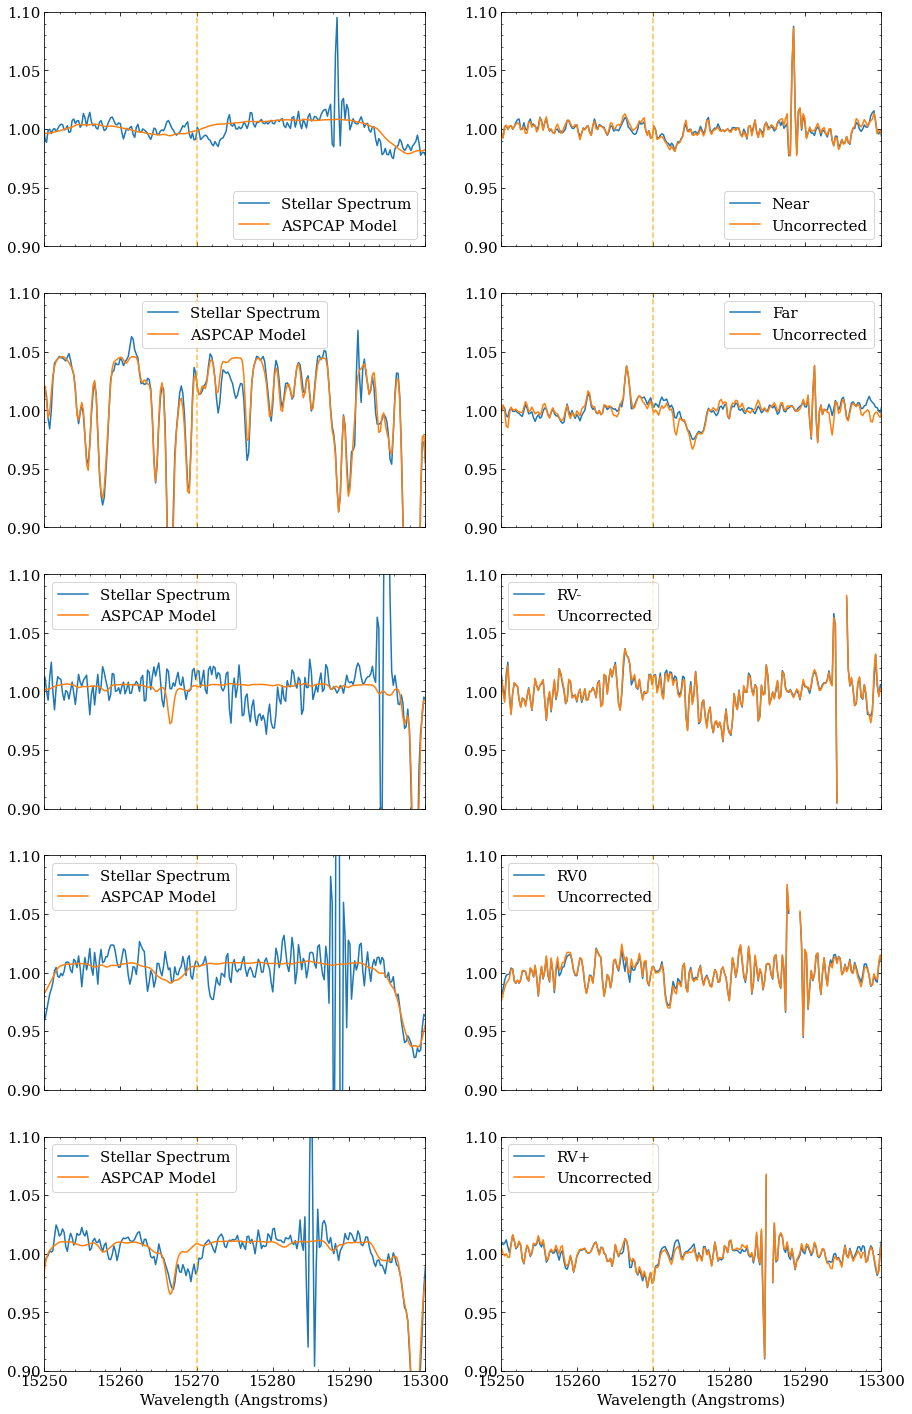

In [16]:
threshold = 0.1 # for masking
xmin, xmax = (15250, 15300)
ymin, ymax = (0.9, 1.1)
wavs = getwavs()
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (15,25), sharex = True)



titles = ['Near', 'Far', 'RV-', 'RV0', 'RV+']
for i in range(len(selected)):
    star_row = selected[i]
    title = titles[i]
    axs = axes[i, :]
    
    star = fits.open(getspecpath(star_row))
    spec, model = (star[1].data, star[3].data)
    stellar_res = np.divide(spec, model)
    mask = np.abs(stellar_res - np.nanmedian(stellar_res)) > threshold * np.nanmedian(stellar_res)
    stellar_res = ma.array(stellar_res, mask = mask)


    medres = get_residual(star_row['TEFF'], star_row['LOGG'], star_row['M_H']).data
    res = medres[0, :]
    res[res - np.nanmedian(res) > 0.01] = 1
    mask = np.abs(res - np.nanmedian(res)) > threshold * np.nanmedian(res)
    res = ma.array(res, mask = mask)


#     fig, axs = plt.subplots(nrows = 1, ncols =2, figsize = (16,6))
    
#     axs[0].set_title('Spectra + ASPCAP')
    axs[0].plot(wavs, spec, label = 'Stellar Spectrum')
    axs[0].plot(wavs, model, label = 'ASPCAP Model')
    axs[0].set_xlim(xmin, xmax)
    axs[0].set_ylim(ymin, ymax)
    axs[0].legend()


#     axs[1].set_title('Corrected Residual')
    axs[1].plot(wavs, stellar_res / res, label = title)
    axs[1].plot(wavs, stellar_res, label = 'Uncorrected')
    axs[1].set_xlim()
    axs[1].set_xlim(xmin, xmax)
    axs[1].set_ylim(ymin, ymax)
    axs[1].legend()
    
    if i == 4:
        axs[0].set_xlabel('Wavelength (Angstroms)')
        axs[1].set_xlabel('Wavelength (Angstroms)')
#     axs[1].legend()
    
    # Highlight DIB location
    half_dib_highlight = 5
#     axs[0].fill_between([15270 - half_dib_highlight, 15270 + half_dib_highlight], 
#                         [1.2, 1.2], [0, 0], color = 'orange', alpha = 0.2)
#     axs[1].fill_between([15270 - half_dib_highlight, 15270 + half_dib_highlight], 
#                         [1.2, 1.2], [0, 0], color = 'orange', alpha = 0.2)
    axs[0].plot([15270, 15270], [ymin, ymax], color = 'orange', linestyle = 'dashed', alpha = 0.7)
    axs[1].plot([15270, 15270], [ymin, ymax], color = 'orange', linestyle = 'dashed', alpha = 0.7)


    
#     fig.suptitle(title)

    
#     plt.show()
plt.show()

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


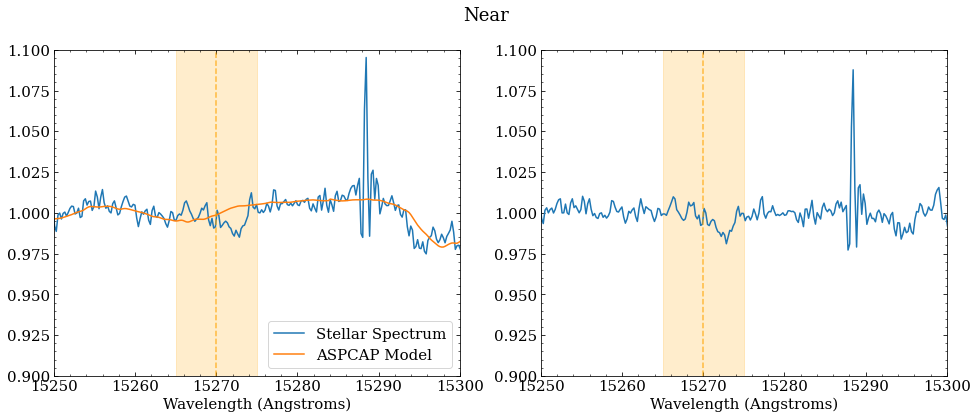

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


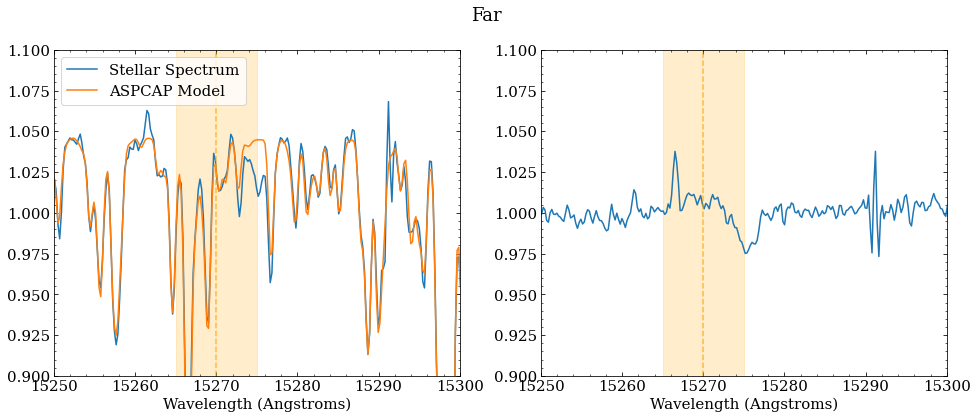

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


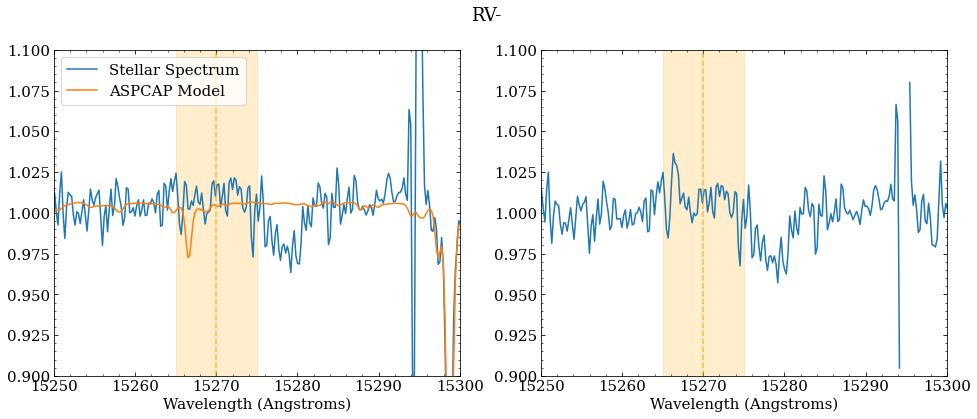

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


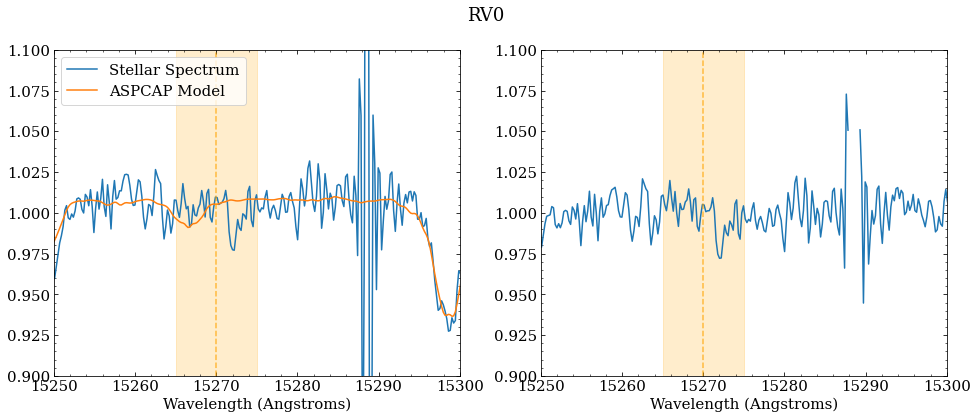

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


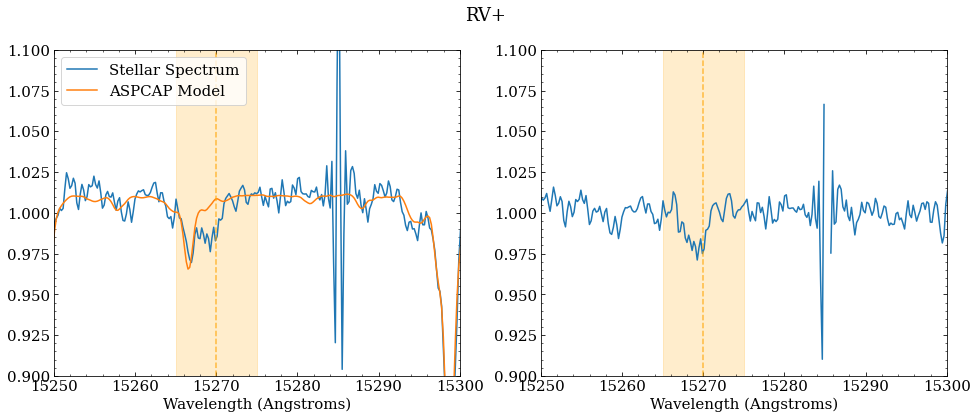

In [17]:
threshold = 0.1 # for masking
xmin, xmax = (15250, 15300)
ymin, ymax = (0.9, 1.1)
wavs = getwavs()


titles = ['Near', 'Far', 'RV-', 'RV0', 'RV+']
for i in range(len(selected)):
    star_row = selected[i]
    title = titles[i]
    
    star = fits.open(getspecpath(star_row))
    spec, model = (star[1].data, star[3].data)
    stellar_res = np.divide(spec, model)
    mask = np.abs(stellar_res - np.nanmedian(stellar_res)) > threshold * np.nanmedian(stellar_res)
    stellar_res = ma.array(stellar_res, mask = mask)


    medres = get_residual(star_row['TEFF'], star_row['LOGG'], star_row['M_H']).data
    res = medres[0, :]
    res[res - np.nanmedian(res) > 0.01] = 1
    mask = np.abs(res - np.nanmedian(res)) > threshold * np.nanmedian(res)
    res = ma.array(res, mask = mask)


    fig, axs = plt.subplots(nrows = 1, ncols =2, figsize = (16,6))
    
#     axs[0].set_title('Spectra + ASPCAP')
    axs[0].plot(wavs, spec, label = 'Stellar Spectrum')
    axs[0].plot(wavs, model, label = 'ASPCAP Model')
    axs[0].set_xlim(xmin, xmax)
    axs[0].set_ylim(ymin, ymax)
    axs[0].set_xlabel('Wavelength (Angstroms)')
    axs[0].legend()


#     axs[1].set_title('Corrected Residual')
    axs[1].plot(wavs, stellar_res / res, label = 'Stellar Residual')
#     axs[1].plot(wavs, res, label = 'Median Residual')
    axs[1].set_xlim()
    axs[1].set_xlim(xmin, xmax)
    axs[1].set_ylim(ymin, ymax)
    axs[1].set_xlabel('Wavelength (Angstroms)')
#     axs[1].legend()
    
    # Highlight DIB location
    half_dib_highlight = 5
    axs[0].fill_between([15270 - half_dib_highlight, 15270 + half_dib_highlight], 
                        [1.2, 1.2], [0, 0], color = 'orange', alpha = 0.2)
    axs[1].fill_between([15270 - half_dib_highlight, 15270 + half_dib_highlight], 
                        [1.2, 1.2], [0, 0], color = 'orange', alpha = 0.2)
    axs[0].plot([15270, 15270], [ymin, ymax], color = 'orange', linestyle = 'dashed', alpha = 0.7)
    axs[1].plot([15270, 15270], [ymin, ymax], color = 'orange', linestyle = 'dashed', alpha = 0.7)


    
    fig.suptitle(title)

    
    plt.show()



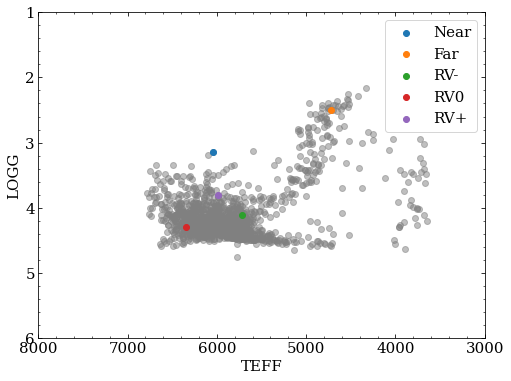

In [18]:
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(CA_clean['TEFF'], CA_clean['LOGG'], color = 'grey', alpha = 0.5)
for i in range(len(selected)):
    star_row = selected[i]
    ax.scatter(star_row['TEFF'], star_row['LOGG'], label= titles[i])
ax.set_xlim(8000, 3000)
ax.set_ylim(6,1)
ax.set_xlabel('TEFF')
ax.set_ylabel('LOGG')
ax.legend()
plt.show()

In [19]:
CA_sorted = CA_clean[np.argsort(1000/CA_clean['GAIAEDR3_PARALLAX'])]

In [20]:
res_data = np.zeros((len(CA_sorted), 8575))

for i in range(len(CA_sorted)):
    row = CA_sorted[i]
    aspcap = fits.open(getspecpath(row))
    apstar = fits.open(getapstarpath(aspcap))
    medres = get_residual(row['TEFF'], row['LOGG'], row['M_H'])
    
    if medres.data is None:
        res_data[i] = np.nan
        continue
    
    bitmask = create_mask(apstar[3].data[0], skipflags = [10,11])
    
    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        stellar_res = ma.array(np.divide(aspcap[1].data, aspcap[3].data), mask = bitmask)
        corrected_res = np.divide(stellar_res, medres.data[0])
    
    res_data[i] = corrected_res

In [21]:
clean = np.where(np.all(np.isnan(res_data), axis = 1) == False)[0]
res_data_clean = res_data[clean]
rv = CA_sorted['VHELIO_AVG'][clean]


In [22]:
print(res_data_clean[50, 700])

0.9977902356571651


In [23]:
res_data_clean.shape

(1240, 8575)

In [24]:
np.log10(1)
np.log10(0.95)

-0.022276394711152253

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


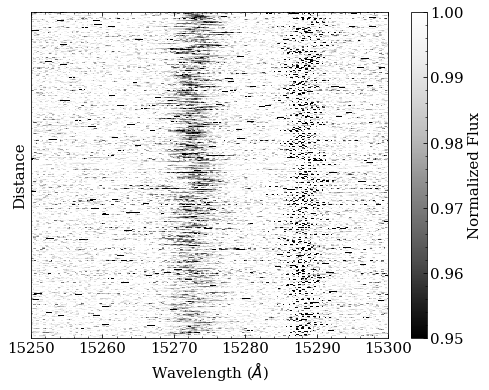

In [25]:
fig, ax = plt.subplots(figsize = (8,6))

norm = colors.Normalize(0.95, 1)
# norm = colors.LogNorm(-0.025, 0)
im = ax.pcolormesh(wavs, np.arange(len(clean)), res_data_clean, cmap = 'Greys_r',norm = norm) #cmap = 'Greys_r')



ax.set_xlabel(r'Wavelength ($\AA$)')
ax.set_ylabel('Distance')
ax.set_yticks([])
# ax.set_xlim(15200, 15500)
ax.set_xlim(15250, 15300)

DIBposition = 15272.42
# ax.plot([DIBposition, DIBposition], [0.95, 1.05],  linestyle = 'dashed', label = '15272 $\AA$')

fig.colorbar(im, label = 'Normalized Flux')

plt.show()

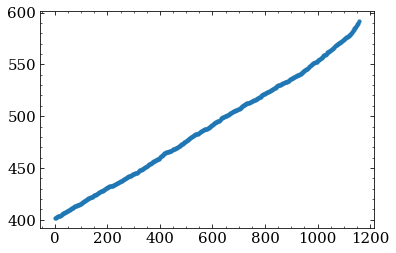

In [26]:
plt.plot(1000/CA_sorted['GAIAEDR3_PARALLAX'][50:-50], marker = '.', alpha = 0.5)

plt.show()

In [27]:
wavs_rv = np.zeros((len(clean), len(wavs)))

# wavs_rv = wavshift(wavs, rv)
for i in range(len(clean)):
    wavs_rv[i,:] = wavshift(wavs, rv[i])

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


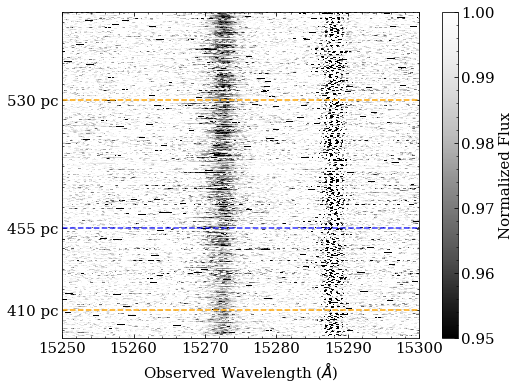

In [28]:
fig, ax = plt.subplots(figsize = (8,6))

norm = colors.Normalize(0.95, 1)
# norm = colors.LogNorm(-0.025, 0)
im = ax.pcolormesh(wavs_rv, np.arange(len(clean)), res_data_clean, cmap = 'Greys_r',norm = norm) #cmap = 'Greys_r')



ax.set_xlabel(r'Observed Wavelength ($\AA$)')
ax.set_ylabel('')
ax.set_yticks([108, 420, 907])
ax.set_yticklabels(['410 pc', '455 pc', '530 pc'])
# ax.set_xlim(15200, 15500)
ax.set_xlim(15250, 15300)

DIBposition = 15272.42
# ax.plot([DIBposition, DIBposition], [0.95, 1.05],  linestyle = 'dashed', label = '15272 $\AA$')

fig.colorbar(im, label = 'Normalized Flux')

ax.plot([*ax.get_xlim()], [108, 108], linestyle = 'dashed', color = 'orange', alpha= 1)
ax.plot([*ax.get_xlim()], [420, 420], linestyle = 'dashed', color = 'blue', alpha= 0.8)
ax.plot([*ax.get_xlim()], [907, 907], linestyle = 'dashed', color = 'orange', alpha= 1)

plt.show()

In [29]:
print(np.where(1000/CA_sorted['GAIAEDR3_PARALLAX']> 530)[0])

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


[ 907  908  909  910  911  912  913  914  915  916  917  918  919  920
  921  922  923  924  925  926  927  928  929  930  931  932  933  934
  935  936  937  938  939  940  941  942  943  944  945  946  947  948
  949  950  951  952  953  954  955  956  957  958  959  960  961  962
  963  964  965  966  967  968  969  970  971  972  973  974  975  976
  977  978  979  980  981  982  983  984  985  986  987  988  989  990
  991  992  993  994  995  996  997  998  999 1000 1001 1002 1003 1004
 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018
 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032
 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046
 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1060
 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070 1071 1072 1073 1074
 1075 1076 1077 1078 1079 1080 1081 1082 1083 1084 1085 1086 1087 1088
 1089 1090 1091 1092 1093 1094 1095 1096 1097 1098 1099 1100 1101 1102
 1103 

In [45]:
import glob
fits.open(glob.glob('ResidualsFiles/*')[0])[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
NBIN    =                    0                                                  
TMIN    =                 7250                                                  
TMAX    =                 7400                                                  
GMIN    =                 -1.0                                                  
GMAX    =                 -0.8                                                  
MMIN    =                 -2.3                                                  
MMAX    =                 -2.0                                                  
CRVAL1  =                   

In [105]:
from dustmaps.bayestar import BayestarWebQuery
from astropy.coordinates import SkyCoord
import astropy.units as u
l0, b0 = (163., -8.0)
l = np.arange(l0 - 10., l0 + 10., 0.05)
b = np.arange(b0 - 10., b0 + 10., 0.05)
l, b = np.meshgrid(l, b)
coords = SkyCoord(l*u.deg, b*u.deg,
                  distance=455.*u.kpc, frame='galactic')
# coords = SkyCoord(l = 160., b = -10., unit = 'deg', frame = 'galactic')

In [106]:
bayestar = BayestarWebQuery(version='bayestar2019')
reddening = bayestar(coords, mode='random_sample').astype(float)

In [107]:
CA_star_coords = SkyCoord(l = CA_clean['GLON'], b = CA_clean['GLAT'], unit = 'deg', frame = 'galactic')

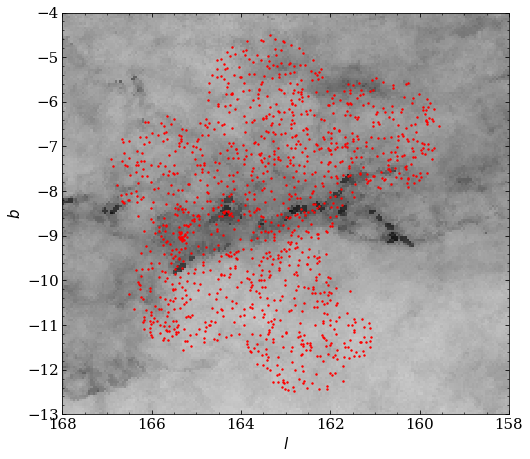

In [119]:
extent = (np.min(coords.l.value), np.max(coords.l.value), np.min(coords.b.value), np.max(coords.b.value))

fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(
    np.sqrt(reddening)[::,::-1],
    vmin=0.,
    vmax=2.,
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal',
    extent = extent
)

ax.scatter(CA_star_coords.l, CA_star_coords.b, s = 2, c= 'r')
ax.set_xlim(168, 158)
ax.set_ylim(-13,-4)

ax.set_xlabel('$l$')# (J2000)')
ax.set_ylabel('$b$')# (J2000)')
plt.show()

In [122]:
x = np.arange(8).reshape(4,2)
for row in x:
    print(row)

[0 1]
[2 3]
[4 5]
[6 7]


In [123]:
x

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

In [124]:
CA_clean

APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,ASPCAP_CHI2,PARAMFLAG [9],ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,X_H [27],X_H_ERR [27],X_M [27],X_M_ERR [27],ELEM_CHI2 [27],ELEMFRAC [27],EXTRATARG,MEMBERFLAG,MEMBER,X_H_SPEC [27],X_M_SPEC [27],TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
bytes30,bytes6,bytes20,bytes30,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,bytes32,float32,float32,int32,int32,int32,int32,int32,int32,bytes132,bytes32,bytes32,int32,float32,float32,int64,bytes132,int64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,int64,int64,bytes256,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32
2M04063599+3531431,apo25m,CA_162-11_btx,none,61.649991,35.528664,161.72526279006618,-12.251131230980798,11.366,0.022,11.086,0.03,11.0,0.02,0.07252261,RJCE_WISE,0.07252261,0.3256324,0,0,0,-2147483646,0,0,APOGEE2_CCLOUD_AS4,apogee2-manga,as4_btx,1,118.38362,118.67717,0,,0,,23.565107,0.0,0.037380762,6167.5757,4.543069,-0.22577177,0.0,0.0,3.042645,21.429415,18.112465,0,1,213.0,0.0,-9999.99,9999.99,-9999.99,9999.99,219166683557038592,2.393143,0.0140943,-4.416,0.0158651,-18.412247,0.0103415,12.6767,13.0943,12.089,24.1771,0.923591,413.01935,411.00797,415.3062,413.5